### Bayesian Prediction Model

In [313]:
import numpy as np
import scipy
import random
import urllib
import matplotlib.pyplot as plt
import json

In [314]:
random.seed(0) #set an initial seed so that we can reproduce consistently

In [315]:
def readJSONfromFile(fname):
    yelp_data = []
    with open(fname) as f:
        for line in f:
            yelp_data.append(json.loads(line))
    return yelp_data

In [354]:
Iu = readJSONfromFile('data/yelp_Iu.json')

In [355]:
Iu = Iu[0]

In [356]:
len(Iu)

721779

In [357]:
#Iu['PmgqNO0-5Y3e3UoR61TD7w']

In [358]:
#some data preprocessing on threshold for each Iu
user_count_dict =dict()
for user in Iu:
    if len(Iu[user]) not in user_count_dict:
        user_count_dict[len(Iu[user])] = 1
    else:
        user_count_dict[len(Iu[user])]+=1

In [359]:
Iu_filtered = dict()
for user in Iu:
    if len(Iu[user])>=10:
        Iu_filtered[user] = Iu[user]

In [360]:
len(Iu_filtered)

45472

In [361]:
I = readJSONfromFile('data/yelp_restaurant_data.json')

In [362]:
I = I[0]

In [363]:
AllRest = []
for i in I:
    AllRest.append(i['business_id'])

In [364]:
AllUser = Iu_filtered.keys()
Iu = Iu_filtered

In [365]:
len(AllUser)   #U set

45472

In [366]:
len(AllRest)   # I set

48485

In [367]:
AllRestSet = set(AllRest)   #has the set of all restaurant ids

In [378]:
Lambda = 1
Alpha = 1e-5
K = 10

In [28]:
Gamma_u = dict()
Gamma_r = dict()   #Latent factor variables
for user in AllUser:
    Gamma_u[user] = np.random.rand(K)
for rest in AllRest:
    Gamma_r[rest] = np.random.rand(K)

In [20]:
import math
def vlen(t):
    su = 0
    for i in t:
        su += i*i
    return su

In [369]:
def logit(t):
    return np.exp(-t)/(1+np.exp(-t))

In [370]:
def sigmoid(t):
    return 1-logit(t)

In [371]:
def generate_validation_set(Iu, AllRestSet):
    #to be used every 10k iterations
    triple_arr = []
    for i in range(1000):
        user = np.random.choice(Iu.keys())  #pick user
        irest = np.random.choice(Iu[user])  #pick item i
        jrest = np.random.choice(list(AllRestSet - set(Iu[user])))  #pick item j
        triple_arr.append([user,irest,jrest])
    return triple_arr
    

In [345]:
def loss_objective(user, rest_i, rest_j, Lambda):
    su=0
    xuij = np.dot(Gamma_u[user],Gamma_r[irest]-Gamma_r[jrest])
    su += np.log(sigmoid(xuij))
    su -= Lambda* np.square(np.linalg.norm(Gamma_u[user]))
    su -= Lambda * np.square(np.linalg.norm(Gamma_r[rest_i]))
    su -= Lambda * np.square(np.linalg.norm(Gamma_r[rest_j]))
    return su

In [372]:
val_arr = generate_validation_set(Iu, AllRestSet)

In [376]:
def val_loss(val_arr, Gamma_u,Gamma_r):
    su=0
    for i in range(len(val_arr)):
        user = val_arr[i][0]
        irest = val_arr[i][1]
        jrest = val_arr[i][2]
        xuij = np.dot(Gamma_u[user],Gamma_r[irest]-Gamma_r[jrest])
        su += np.log(sigmoid(xuij))
    su/= len(val_arr)  
    for user in Gamma_u:
        su -= Lambda* np.square(np.linalg.norm(Gamma_u[user]))
    for rest in Gamma_r:
        su -= Lambda * np.square(np.linalg.norm(Gamma_r[rest]))
    #for jrest in 
    #   su -= Lambda * np.linalg.norm(Gamma_r[jrest])
    return su

In [374]:
def SGD(Lambda, K):
    Gamma_u = dict()
    Gamma_r = dict()
    for user in AllUser:
        Gamma_u[user] = np.random.rand(K)
    for rest in AllRest:
        Gamma_r[rest] = np.random.rand(K)
    
    #train_loss_arr = []
    val_loss_arr = []
    max_iterations = 5000
    batch_size = 1
    
    for i in range(max_iterations):
        #if i%100 ==0:
        #    print i
        delta_u_temp =0
        delta_i_temp = 0
        delta_j_temp = 0
        #for j in range(batch_size):
        user = np.random.choice(Iu.keys())  #pick user
        irest = np.random.choice(Iu[user])  #pick item i
        jrest = np.random.choice(list(AllRestSet - set(Iu[user])))    #pick item j

            #print(len(Gamma_u[user]))
        xuij = np.dot(Gamma_u[user],Gamma_r[irest]-Gamma_r[jrest])
        delta_u_temp += Alpha*(logit(xuij)*(Gamma_r[irest]-Gamma_r[jrest]))
        delta_i_temp += Alpha*(logit(xuij)*(Gamma_u[user]))
        delta_j_temp += Alpha*(logit(xuij)*(-Gamma_u[user]))
        Gamma_u[user] += delta_u_temp
        Gamma_r[irest] += delta_i_temp
        Gamma_r[jrest] += delta_j_temp 
        
        for user in Gamma_u:
            Gamma_u[user] += Alpha * Lambda* Gamma_u[user]
        for rest in Gamma_r:
            Gamma_r[rest] += Alpha* Lambda* Gamma_r[rest]
        
        #train_loss_arr.append(loss_objective(user, irest, jrest,Lambda))
        if i%100 ==0 :
            val_loss_arr.append(val_loss(val_arr, Gamma_u, Gamma_r))
            print val_loss_arr[-1]
    return Gamma_u, Gamma_r, val_loss_arr

In [ ]:
gu,gi, arr = SGD(1,100)

-3132236.42417


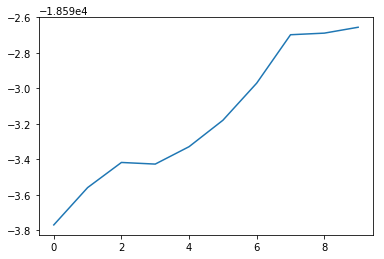

In [253]:
plt.plot(np.arange(len(arr)), arr)
plt.show()
